In [1]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# 實作一個可以讀取 stanford dog (mini) 的 Pytorch dataset

class DogDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        
        self.filenames = filenames    # 資料集的所有檔名
        self.labels = labels          # 影像的標籤
        self.transform = transform    # 影像的轉換方式
 
    def __len__(self):
        
        return len(self.filenames)    # return DataSet 長度
 
    def __getitem__(self, idx):       # idx: Inedx of filenames
        
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image) # Transform image
        label = np.array(self.labels[idx])
                
        return image, label           # return 模型訓練所需的資訊


## 定義 Normalize 以及 Transform 的參數

In [ ]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
 
test_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

## 將每一個類別以 8 : 2 的比例分割成 Training data 和 Testing data 傳至 dataloader

In [4]:
def split_Train_Val_Data(data_dir):
    
    dataset = ImageFolder(data_dir) 
    
    # 建立 N 類的 list
    character = [[] for i in range(len(dataset.classes))]
    # print(character)
    
    # 將每一類的檔名依序存入相對應的 list
    for x, y in dataset.samples:
        character[y].append(x)
      
    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []
    
    for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
        
        np.random.seed(42)
        np.random.shuffle(data)
            
        # -------------------------------------------
        # 將每一類都以 8:2 的比例分成訓練資料和測試資料
        # -------------------------------------------
        
        num_sample_train = int(len(data) * 0.8)
        num_sample_test = len(data) - num_sample_train
        
        # print(str(i) + ': ' + str(len(data)) + ' | ' + str(num_sample_train) + ' | ' + str(num_sample_test))
        
        for x in data[:num_sample_train] : # 前 80% 資料存進 training list
            train_inputs.append(x)
            train_labels.append(i)
            
        for x in data[num_sample_train:] : # 後 20% 資料存進 testing list
            test_inputs.append(x)
            test_labels.append(i)

    train_dataloader = DataLoader(DogDataset(train_inputs, train_labels, train_transformer),
                                  batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(DogDataset(test_inputs, test_labels, test_transformer),
                                  batch_size = batch_size, shuffle = False)
 
    return train_dataloader, test_dataloader

### Part 2: 建立 CNN Model

## 訓練參數設定

In [ ]:
batch_size = 32
lr = 1e-3
epochs = 50

data_dir = 'stanford_dog'

## 利用 Pytorch 內建的 CNN model 來進行訓練且 torchsummary 來印出模型的架構資訊

In [6]:
# 2.3. 利用 Pytorch 內建的 CNN model 來進行訓練且 torchsummary 來印出模型的架構資訊

train_dataloader, test_dataloader = split_Train_Val_Data(data_dir)

C = models.vgg16(pretrained=True).to(device)     # 使用內建的 model 或是自行設計的 model
optimizer_C = optim.SGD(C.parameters(), lr = lr) # 選擇你想用的 optimizer

summary(C, (3, 244, 244))                        # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3 * 224 * 224)

# Loss function
criterion = nn.CrossEntropyLoss()                # 選擇想用的 loss function

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

## 儲存訓練資訊的 List

In [7]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0

## 實作模型訓練和測試模型效能

In [8]:
if __name__ == '__main__':    
    
    for epoch in range(epochs):
        
        start_time = time.time()
        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss_C = 0.0

        C.train() # 設定 train 或 eval
      
        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        
        for i, (x, label) in enumerate(train_dataloader) :
                     
            x, label = x.to(device), label.to(device)
                        
            optimizer_C.zero_grad()                         # 清空梯度

            train_output = C(x)                             # 將訓練資料輸入至模型進行訓練
            train_loss = criterion(train_output, label)     # 計算 loss
            
            train_loss.backward()                           # 將 loss 反向傳播
            optimizer_C.step()                              # 更新權重
            
            
            # 計算訓練資料的準確度 (correct_train / total_train)
            _, predicted = torch.max(train_output.data, 1)
            total_train += label.size(0)
            correct_train += (predicted == label).sum()

            train_loss_C += train_loss.item()
            iter += 1
                    
        print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
              (epoch + 1, train_loss_C / iter, correct_train / total_train))

        
        # --------------------------
        # Testing Stage
        # --------------------------
        
        C.eval() # 設定 train 或 eval
          
        for i, (x, label) in enumerate(test_dataloader) :
          
            with torch.no_grad():                           # 測試階段不需要求梯度
                x, label = x.to(device), label.to(device)
                
                test_output = C(x)                          # 將測試資料輸入至模型進行測試
                test_loss = criterion(test_output, label)   # 計算 loss
                
                
                # 計算測試資料的準確度 (correct_test / total_test)
                _, predicted = torch.max(test_output.data, 1)
                total_test += label.size(0)
                correct_test += (predicted == label).sum()
        
        print('Testing acc: %.3f' % (correct_test / total_test))
                                     
        train_acc.append(100 * (correct_train / total_train).cpu()) # training accuracy
        test_acc.append(100 * (correct_test / total_test).cpu())    # testing accuracy
        loss_epoch_C.append(train_loss_C / iter)                    # loss 

        end_time = time.time()
        print('Cost %.3f(secs)' % (end_time - start_time))
    

epoch: 1 / 50
Training epoch: 1 / loss_C: 5.587 | acc: 0.014
Testing acc: 0.020
Cost 122.854(secs)
epoch: 2 / 50
Training epoch: 2 / loss_C: 4.714 | acc: 0.040
Testing acc: 0.041
Cost 122.754(secs)
epoch: 3 / 50
Training epoch: 3 / loss_C: 4.258 | acc: 0.074
Testing acc: 0.106
Cost 122.786(secs)
epoch: 4 / 50
Training epoch: 4 / loss_C: 3.823 | acc: 0.120
Testing acc: 0.144
Cost 122.284(secs)
epoch: 5 / 50
Training epoch: 5 / loss_C: 3.437 | acc: 0.179
Testing acc: 0.222
Cost 121.508(secs)
epoch: 6 / 50
Training epoch: 6 / loss_C: 3.119 | acc: 0.224
Testing acc: 0.398
Cost 121.548(secs)
epoch: 7 / 50
Training epoch: 7 / loss_C: 2.878 | acc: 0.266
Testing acc: 0.429
Cost 121.744(secs)
epoch: 8 / 50
Training epoch: 8 / loss_C: 2.642 | acc: 0.315
Testing acc: 0.335
Cost 121.537(secs)
epoch: 9 / 50
Training epoch: 9 / loss_C: 2.466 | acc: 0.344
Testing acc: 0.521
Cost 121.493(secs)
epoch: 10 / 50
Training epoch: 10 / loss_C: 2.356 | acc: 0.376
Testing acc: 0.547
Cost 121.448(secs)
epoch: 1

## 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖。

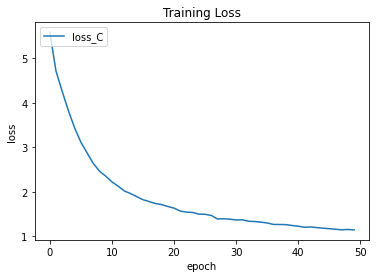

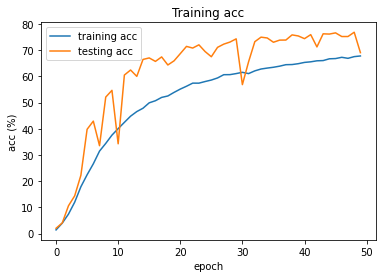

In [9]:
fig_dir = './fig/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

plt.figure()
plt.plot(list(range(epochs)), loss_epoch_C) # plot your loss
plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.savefig(fig_dir + 'loss.png')
plt.show()

plt.figure()
plt.plot(list(range(epochs)), train_acc)    # plot your training accuracy
plt.plot(list(range(epochs)), test_acc)     # plot your testing accuracy
plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.savefig(fig_dir + 'acc.png')
plt.show()